In [25]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
import sys

sys.path.append("../")

In [27]:
import os
import torch

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

# sns.set_style("whitegrid")

In [29]:
from pathlib import Path

results_dir = Path(f"../data/results/")

!ls {results_dir}


auroc.json  qa_metrics.json  qa_metrics.tex


In [32]:
import json

with open(results_dir / "qa_metrics.json", "r") as f:
    qa_metrics = json.load(f)

qa_metrics_df = pd.DataFrame(qa_metrics)
qa_metrics_df.head()


,Model,Dataset,Temperature,Prompt,ROUGE-L,Accuracy
0,Llama-3.1-8B,NQ-Open,High,Few-Shot,0.23,0.26
1,Llama-3.1-8B,NQ-Open,High,Zero-Shot,0.21,0.23
2,Llama-3.1-8B,NQ-Open,Low,Few-Shot,0.25,0.28
3,Llama-3.1-8B,NQ-Open,Low,Zero-Shot,0.22,0.24
4,Mistral-0.3-7B,NQ-Open,High,Few-Shot,0.17,0.19


In [33]:
import json

with open(results_dir / "auroc.json", "r") as f:
    auroc_results = json.load(f)

auroc_df = pd.DataFrame(auroc_results)

In [34]:
auroc_df.head()

,model,prompt,temperature,dataset,metric,auroc,layer
0,Llama-3.1-8B,Few-Shot,High,NQ-Open,Diff-eRank,0.756894,1.0
1,Llama-3.1-8B,Few-Shot,High,NQ-Open,LogDet,0.594276,1.0
2,Llama-3.1-8B,Few-Shot,High,NQ-Open,eRank,0.767473,1.0
3,Llama-3.1-8B,Few-Shot,High,NQ-Open,Diff-eRank,0.764786,2.0
4,Llama-3.1-8B,Few-Shot,High,NQ-Open,LogDet,0.605132,2.0


In [35]:
auroc_df["prompt"].value_counts()

prompt
Few-Shot           1790
Zero-Shot           596
Few-Shot-Trivia     198
Name: count, dtype: int64

<Figure size 6000x3600 with 0 Axes>

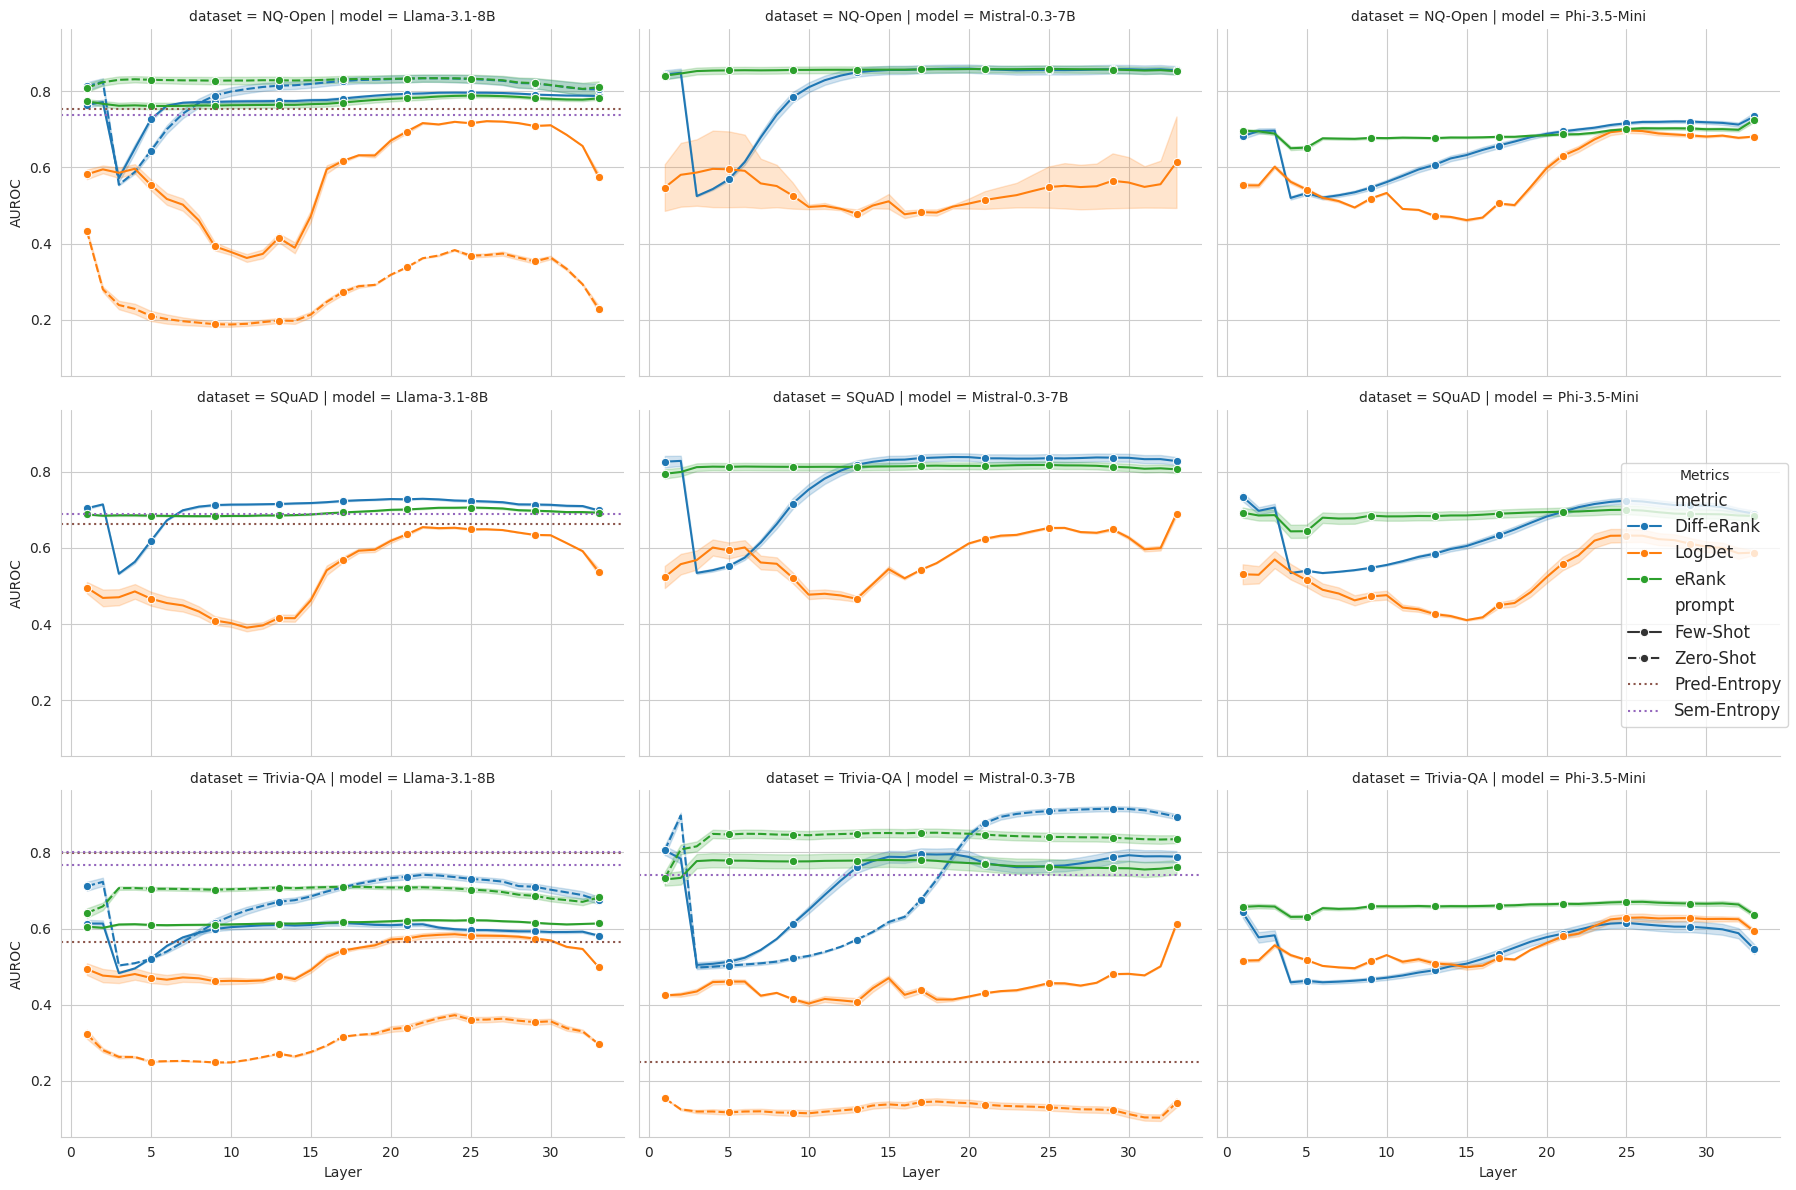

In [36]:
sns.set_style("whitegrid")

# Reset to default font sizes
plt.rcParams.update({'font.size': 10,
                    'axes.labelsize': 10,
                    'axes.titlesize': 10,
                    'xtick.labelsize': 10,
                    'ytick.labelsize': 10,
                    'legend.fontsize': 10})

df = auroc_df

masks = (
    (df["auroc"] != 0.5) & 
    (df["prompt"] != "Few-Shot-Trivia") &
    (df["layer"] != np.inf)
)
df_plot = df[masks]

plt.figure(figsize=(20, 12), dpi=300)

g = sns.FacetGrid(
    data=df_plot,
    row="dataset", 
    col="model",
    height=4,
    aspect=1.5
)
g.map_dataframe(
    sns.lineplot,
    x="layer",
    y="auroc",
    hue="metric", 
    style="prompt",
    marker="o",
    markevery=4
)

# Add entropy metrics
entropy_colors = {
    "Sem-Entropy": "C4",
    "Pred-Entropy": "C5"
}

entropy_df = df[df["layer"] == np.inf].copy()
for i, dataset in enumerate(g.row_names):
    for j, model in enumerate(g.col_names):
        ax = g.axes[i,j]
        
        entropy_vals = entropy_df[
            (entropy_df["dataset"] == dataset) & 
            (entropy_df["model"] == model)
        ]
        
        for _, row in entropy_vals.iterrows():
            ax.axhline(
                y=row["auroc"],
                color=entropy_colors["Sem-Entropy"] if "Sem-Entropy" in row["metric"] else entropy_colors["Pred-Entropy"],
                linestyle=":",
                label=row["metric"]
            )

g.set_axis_labels("Layer", "AUROC")

# Get handles and labels from the first subplot
handles, labels = g.axes[-1,0].get_legend_handles_labels()

# Remove duplicate labels while preserving order
unique_labels = []
unique_handles = []
for handle, label in zip(handles, labels):
    if label not in unique_labels:
        unique_labels.append(label)
        unique_handles.append(handle)

# Create a single legend with all metrics
plt.figlegend(
    unique_handles,
    unique_labels,
    loc="center right",
    title="Metrics",
    fontsize=12
)

sns.despine()
g.tight_layout()
plt.savefig("../plots/auroc_by_layer.png", dpi=300, bbox_inches="tight")
plt.show()


In [37]:
last_layer_df = (
    auroc_df.sort_values("layer")
    .groupby(["model", "prompt", "temperature", "dataset", "metric"])
    .last()
    .reset_index()
)
last_layer_df.columns = ["Model", "Prompt", "Temperature", "Dataset", "Metric", "AUROC", "Layer"]

merged_df = pd.merge(
    last_layer_df,
    qa_metrics_df,
    on=['Model', 'Dataset', 'Temperature', 'Prompt'],
    how='inner'
)
assert merged_df.shape[0] == last_layer_df.shape[0]
merged_df.head()

max_last_layer_df = (
    merged_df.groupby(["Dataset", "Model", "Metric"])
    .max()
    .reset_index()
)

max_last_layer_df = max_last_layer_df[["Dataset", "Model", "Metric", "AUROC"]].sort_values(by=["Dataset", "Model", "Metric"])

# Define desired metric order
metric_order = ['eRank', 'Diff-eRank', 'LogDet', 'Pred-Entropy', 'Sem-Entropy']

# Sort max_last_layer_df metrics according to metric_order
max_last_layer_df['Metric'] = pd.Categorical(max_last_layer_df['Metric'], categories=metric_order, ordered=True)
max_last_layer_df = max_last_layer_df.sort_values(['Dataset', 'Model', 'Metric'])

# Create pivot table to show metrics by dataset and model
pivot_df = max_last_layer_df.pivot_table(
    index=["Dataset", "Model"],
    columns="Metric", 
    values="AUROC"
).round(3)

# Add ROUGE-L column from qa_metrics_df
rouge_l_df = qa_metrics_df.groupby(["Dataset", "Model"])["ROUGE-L"].max()
pivot_df["ROUGE-L"] = rouge_l_df

pivot_df = pivot_df.sort_index(level=[0,1])

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
display(pivot_df)


/tmp/ipykernel_3770299/334266276.py:34: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_df = max_last_layer_df.pivot_table(


Metric                    eRank  Diff-eRank  LogDet  Pred-Entropy  \
Dataset   Model                                                     
NQ-Open   Llama-3.1-8B    0.826       0.820   0.585         0.753   
          Mistral-0.3-7B  0.861       0.866   0.734           NaN   
          Phi-3.5-Mini    0.730       0.744   0.681           NaN   
SQuAD     Llama-3.1-8B    0.694       0.701   0.547         0.663   
          Mistral-0.3-7B  0.816       0.838   0.697           NaN   
          Phi-3.5-Mini    0.697       0.698   0.594           NaN   
Trivia-QA Llama-3.1-8B    0.690       0.684   0.499         0.799   
          Mistral-0.3-7B  0.845       0.900   0.615         0.250   
          Phi-3.5-Mini    0.641       0.558   0.598           NaN   

Metric                    Sem-Entropy  ROUGE-L  
Dataset   Model                                 
NQ-Open   Llama-3.1-8B          0.738     0.25  
          Mistral-0.3-7B          NaN     0.19  
          Phi-3.5-Mini            NaN     0.21  
SQuAD     Llama-3.1-8B          0.688     0.19  
          Mistral-0.3-7B          NaN     0.16  
          Phi-3.5-Mini            NaN     0.22  
Trivia-QA Llama-3.1-8B          0.800     0.59  
          Mistral-0.3-7B        0.741     0.46  
          Phi-3.5-Mini            NaN     0.46

In [ ]:
def format_rouge_l(val):
    return f"{val:.2f}" if pd.notna(val) else "---"

pivot_df["ROUGE-L"] = pivot_df["ROUGE-L"].apply(format_rouge_l)

latex_table = pivot_df.to_latex(
    float_format="%.3f",
    caption="AUROC scores for different metrics across datasets and models",
    label="tab:auroc_scores",
    column_format="llrrrrrr", # Added an extra r for ROUGE-L column
    multicolumn=True,
    multicolumn_format="c",
    bold_rows=True,
    escape=False
)

# Add some latex formatting
latex_table = latex_table.replace("NaN", "---")  # Replace NaN with dashes
latex_table = latex_table.replace("dataset", "Dataset")
latex_table = latex_table.replace("model", "Model")

print(latex_table)

In [26]:
# Get last layer results
last_layer_df = (
    auroc_df.sort_values("layer")
    .groupby(["model", "prompt", "temperature", "dataset", "metric"])
    .last()
    .reset_index()
)
last_layer_df.columns = ["Model", "Prompt", "Temperature", "Dataset", "Metric", "AUROC", "Layer"]

# Get 20th layer results 
layer_20_df = auroc_df[auroc_df["layer"] == 20].copy()
layer_20_df.columns = ["Model", "Prompt", "Temperature", "Dataset", "Metric", "AUROC", "Layer"]

# Merge both layer results with QA metrics
merged_last_df = pd.merge(
    last_layer_df,
    qa_metrics_df,
    on=['Model', 'Dataset', 'Temperature', 'Prompt'],
    how='inner'
)
assert merged_last_df.shape[0] == last_layer_df.shape[0]

merged_20_df = pd.merge(
    layer_20_df, 
    qa_metrics_df,
    on=['Model', 'Dataset', 'Temperature', 'Prompt'],
    how='inner'
)
assert merged_20_df.shape[0] == layer_20_df.shape[0]

# Process last layer results
max_last_layer_df = (
    merged_last_df.groupby(["Dataset", "Model", "Metric"])
    .max()
    .reset_index()
)
max_last_layer_df = max_last_layer_df[["Dataset", "Model", "Metric", "AUROC"]].sort_values(by=["Dataset", "Model", "Metric"])

# Process 20th layer results
max_20_layer_df = (
    merged_20_df.groupby(["Dataset", "Model", "Metric"])
    .max() 
    .reset_index()
)
max_20_layer_df = max_20_layer_df[["Dataset", "Model", "Metric", "AUROC"]].sort_values(by=["Dataset", "Model", "Metric"])

# Define desired metric order
metric_order = ['eRank', 'Diff-eRank', 'LogDet', 'Pred-Entropy', 'Sem-Entropy']

# Sort metrics according to metric_order
max_last_layer_df['Metric'] = pd.Categorical(max_last_layer_df['Metric'], categories=metric_order, ordered=True)
max_last_layer_df = max_last_layer_df.sort_values(['Dataset', 'Model', 'Metric'])

max_20_layer_df['Metric'] = pd.Categorical(max_20_layer_df['Metric'], categories=metric_order, ordered=True)
max_20_layer_df = max_20_layer_df.sort_values(['Dataset', 'Model', 'Metric'])

# Create combined pivot table with both layer results
pivot_combined = pd.DataFrame(index=pd.MultiIndex.from_product([max_last_layer_df['Dataset'].unique(), 
                                                              max_last_layer_df['Model'].unique()],
                                                              names=['Dataset', 'Model']))

# Add columns for each metric's layer 20 and last layer results
for metric in metric_order:
    last_layer_values = max_last_layer_df[max_last_layer_df['Metric'] == metric].set_index(['Dataset', 'Model'])['AUROC']
    layer_20_values = max_20_layer_df[max_20_layer_df['Metric'] == metric].set_index(['Dataset', 'Model'])['AUROC']
    
    pivot_combined[f'{metric}-20'] = layer_20_values
    pivot_combined[f'{metric}-last'] = last_layer_values

# Add ROUGE-L column
rouge_l_df = qa_metrics_df.groupby(["Dataset", "Model"])["ROUGE-L"].max()
pivot_combined["ROUGE-L"] = rouge_l_df

pivot_combined = pivot_combined.sort_index(level=[0,1]).round(3)
pivot_combined = pivot_combined.dropna(how="all", axis=1)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
display(pivot_combined)


eRank-20  eRank-last  Diff-eRank-20  \
Dataset   Model                                                 
NQ-Open   Llama-3.1-8B       0.786       0.784          0.793   
          Mistral-0.3-7B     0.867       0.861          0.870   
          Phi-3.5-Mini       0.686       0.730          0.693   
SQuAD     Llama-3.1-8B       0.701       0.694          0.730   
          Mistral-0.3-7B     0.824       0.816          0.848   
          Phi-3.5-Mini       0.705       0.697          0.690   
Trivia-QA Llama-3.1-8B       0.712       0.690          0.739   
          Mistral-0.3-7B     0.791       0.780          0.803   
          Phi-3.5-Mini       0.668       0.641          0.588   

                          Diff-eRank-last  LogDet-20  LogDet-last  \
Dataset   Model                                                     
NQ-Open   Llama-3.1-8B              0.789      0.676        0.585   
          Mistral-0.3-7B            0.866      0.518        0.734   
          Phi-3.5-Mini              0.744      0.606        0.681   
SQuAD     Llama-3.1-8B              0.701      0.624        0.547   
          Mistral-0.3-7B            0.838      0.612        0.697   
          Phi-3.5-Mini              0.698      0.539        0.594   
Trivia-QA Llama-3.1-8B              0.684      0.579        0.499   
          Mistral-0.3-7B            0.803      0.423        0.615   
          Phi-3.5-Mini              0.558      0.566        0.598   

                          Pred-Entropy-last  Sem-Entropy-last  ROUGE-L  
Dataset   Model                                                         
NQ-Open   Llama-3.1-8B                0.753             0.738     0.25  
          Mistral-0.3-7B                NaN               NaN     0.19  
          Phi-3.5-Mini                  NaN               NaN     0.21  
SQuAD     Llama-3.1-8B                0.663             0.688     0.19  
          Mistral-0.3-7B                NaN               NaN     0.16  
          Phi-3.5-Mini                  NaN               NaN     0.22  
Trivia-QA Llama-3.1-8B                0.799             0.800     0.59  
          Mistral-0.3-7B              0.250             0.741     0.46  
          Phi-3.5-Mini                  NaN               NaN     0.46

In [23]:
def format_rouge_l(val):
    return f"{val:.2f}" if pd.notna(val) else "---"

pivot_combined["ROUGE-L"] = pivot_combined["ROUGE-L"].apply(format_rouge_l)

# Count number of columns for correct column format string
num_cols = len(pivot_combined.columns)
column_format = "ll" + "r" * num_cols

latex_table = pivot_combined.to_latex(
    float_format="%.3f",
    caption="AUROC scores for different metrics across datasets and models",
    label="tab:auroc_scores", 
    column_format=column_format,
    multicolumn=True,
    multicolumn_format="c",
    bold_rows=True,
    escape=False
)

# Add some latex formatting
latex_table = latex_table.replace("NaN", "---")  # Replace NaN with dashes
latex_table = latex_table.replace("dataset", "Dataset")
latex_table = latex_table.replace("model", "Model")

print(latex_table)

\begin{table}
\caption{AUROC scores for different metrics across Datasets and Models}
\label{tab:auroc_scores}
\begin{tabular}{llrrrrrrrrr}
\toprule
 &  & eRank-20 & eRank-last & Diff-eRank-20 & Diff-eRank-last & LogDet-20 & LogDet-last & Pred-Entropy-last & Sem-Entropy-last & ROUGE-L \\
Dataset & Model &  &  &  &  &  &  &  &  &  \\
\midrule
\multirow[t]{3}{*}{\textbf{NQ-Open}} & \textbf{Llama-3.1-8B} & 0.786 & 0.784 & 0.793 & 0.789 & 0.676 & 0.585 & 0.753 & 0.738 & 0.25 \\
\textbf{} & \textbf{Mistral-0.3-7B} & 0.867 & 0.861 & 0.870 & 0.866 & 0.518 & 0.734 & --- & --- & 0.19 \\
\textbf{} & \textbf{Phi-3.5-Mini} & 0.686 & 0.730 & 0.693 & 0.744 & 0.606 & 0.681 & --- & --- & 0.21 \\
\cline{1-11}
\multirow[t]{3}{*}{\textbf{SQuAD}} & \textbf{Llama-3.1-8B} & 0.701 & 0.694 & 0.730 & 0.701 & 0.624 & 0.547 & 0.663 & 0.688 & 0.19 \\
\textbf{} & \textbf{Mistral-0.3-7B} & 0.824 & 0.816 & 0.848 & 0.838 & 0.612 & 0.697 & --- & --- & 0.16 \\
\textbf{} & \textbf{Phi-3.5-Mini} & 0.705 & 0.697 & 0.690 &

\begin{table}
\caption{AUROC scores for different metrics across Datasets and Models}
\label{tab:auroc_scores}
\begin{tabular}{llrrrrrr}
\toprule
 & Metric & eRank & Diff-eRank & LogDet & Pred-Entropy & Sem-Entropy & ROUGE-L \\
Dataset & Model &  &  &  &  &  &  \\
\midrule
\multirow[t]{3}{*}{\textbf{NQ-Open}} & \textbf{Llama-3.1-8B} & 0.784 & 0.789 & 0.585 & 0.753 & 0.738 & 0.25 \\
\textbf{} & \textbf{Mistral-0.3-7B} & 0.861 & 0.866 & 0.734 & --- & --- & 0.19 \\
\textbf{} & \textbf{Phi-3.5-Mini} & 0.730 & 0.744 & 0.681 & --- & --- & 0.21 \\
\cline{1-8}
\multirow[t]{3}{*}{\textbf{SQuAD}} & \textbf{Llama-3.1-8B} & 0.694 & 0.701 & 0.547 & 0.663 & 0.688 & 0.19 \\
\textbf{} & \textbf{Mistral-0.3-7B} & 0.816 & 0.838 & 0.697 & --- & --- & 0.16 \\
\textbf{} & \textbf{Phi-3.5-Mini} & 0.697 & 0.698 & 0.594 & --- & --- & 0.22 \\
\cline{1-8}
\multirow[t]{3}{*}{\textbf{Trivia-QA}} & \textbf{Llama-3.1-8B} & 0.690 & 0.684 & 0.499 & 0.799 & 0.800 & 0.59 \\
\textbf{} & \textbf{Mistral-0.3-7B} & 0.780 &

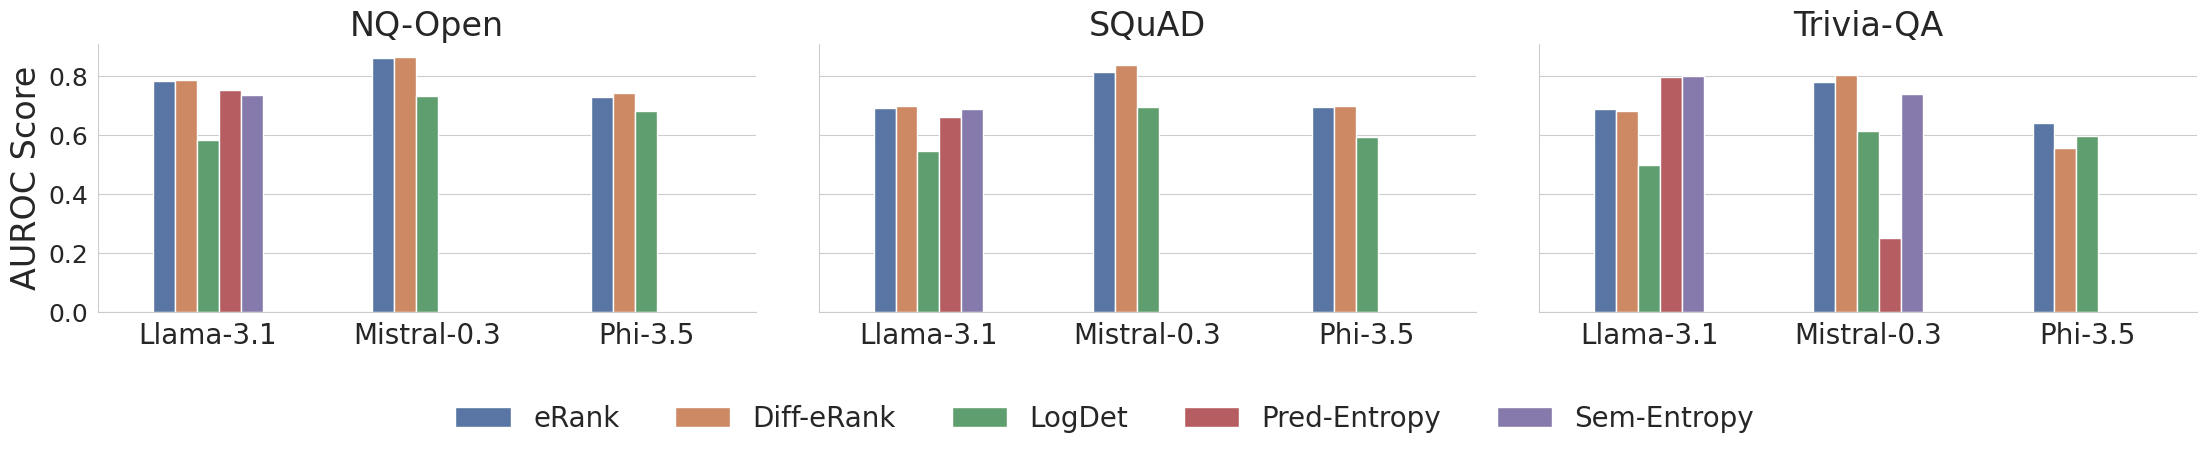

In [68]:
metric_order = ['eRank', 'Diff-eRank', 'LogDet', 'Pred-Entropy', 'Sem-Entropy']

# Set font sizes
plt.rcParams.update({'font.size': 20,
                    'axes.labelsize': 24,
                    'axes.titlesize': 20,
                    'xtick.labelsize': 20,
                    'ytick.labelsize': 18,
                    'legend.fontsize': 20})

df_plot = max_last_layer_df.copy()
df_plot["Model"] = df_plot["Model"].apply(lambda x: "-".join(x.split("-")[:-1]))

g = sns.FacetGrid(
    df_plot,
    col='Dataset', 
    height=4,
    aspect=0.8, # Reduced aspect ratio to make plot narrower
    despine=True,
)
g.map_dataframe(
    sns.barplot,
    x='Model',
    y='AUROC', 
    hue='Metric',
    hue_order=metric_order,
    palette='deep',
    width=0.5,
)

# Set titles and labels for the plot
g.set_titles(col_template='{col_name}')
g.set_axis_labels('', 'AUROC Score')
g.add_legend(title='', bbox_to_anchor=(0.5, -0.0), loc='upper center', ncol=5)

plt.tight_layout(w_pad=0.2) # Reduced spacing between subplots
plt.savefig("../plots/max_auroc_barplot.png", dpi=300, bbox_inches="tight")

plt.show()


# TODO: Add attention score

In [37]:
attn_path = Path("/data/hallucinations/activations/nq_open/llama_3.1_8b_instruct/temp_1.0_attentions_only__prompt_qa_short_zero_shot__seed_42")
!ls {attn_path}


activations  answers.json  config.yaml


In [35]:
attn_path = Path("/data/hallucinations/activations/nq_open/llama_3.1_8b_instruct/sampling_high_temp_with_activations_and_attentions__prompt_qa_short_few_shot_sep__seed_42/log_det_attn.pt")
atn_scores = torch.load(attn_path)
atn_scores = torch.stack(atn_scores).sum(dim=2).to(torch.float32)
atn_scores.shape


/tmp/ipykernel_4095263/696049981.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  atn_scores = torch.load(attn_path)


FileNotFoundError: [Errno 2] No such file or directory: '/data/hallucinations/activations/nq_open/llama_3.1_8b_instruct/sampling_high_temp_with_activations_and_attentions__prompt_qa_short_few_shot_sep__seed_42/log_det_attn.pt'